<a href="https://colab.research.google.com/github/Murcha1990/ML_Course_PT/blob/main/Lecture5_IntroDL_CV/PT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://i.vas3k.blog/7sc.jpg" height="400">

# Полносвязные и сверточные нейронные сети
</center>

### План семинара

1. Учимся работать с картинками средствами **Python**, **NumPy** и **PyTorch**
2. Применяем константные свёртки к изображениям
3. Сравниваем работу полносвязных и свёрточных сетей на датасете MNIST


In [1]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

# 1. Разбираемся что такое картинка



In [2]:
# при работе в колабе, скачайте изображение этой командой
!wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg

--2026-02-20 14:45:20--  https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73801 (72K) [image/jpeg]
Saving to: ‘butterfly.jpg’

butterfly.jpg       100%[===================>]  72.07K  --.-KB/s    in 0.005s  

2026-02-20 14:45:20 (14.8 MB/s) - ‘butterfly.jpg’ saved [73801/73801]



Image format: JPEG; shape: (640, 427); color scheme: RGB


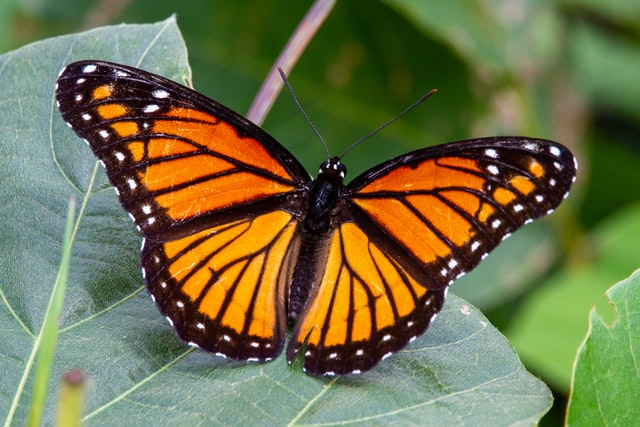

In [3]:
# !pip install Pillow
from PIL import Image

img = Image.open("./butterfly.jpg")
print(f"Image format: {img.format}; shape: {img.size}; color scheme: {img.mode}")
img

## Матричное представление изображения

На самом деле каждая картинка это набор пикселей. Если мы попросим питон показать нам картинку, он покажет матрицу из чисел.  Каждому пикселю в этой матрице соответствует число. Это число сообщает нам о том, насколько этот пиксель яркий. Яркость можно измерять в разных шкалах. В нашем случае она измеряется по шкале от $0$ до $1$.

Цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему. Такой формат хранения картинки называется [RGB-форматом.](https://www.wikiwand.com/ru/RGB)

Image array shape: (427, 640, 3)


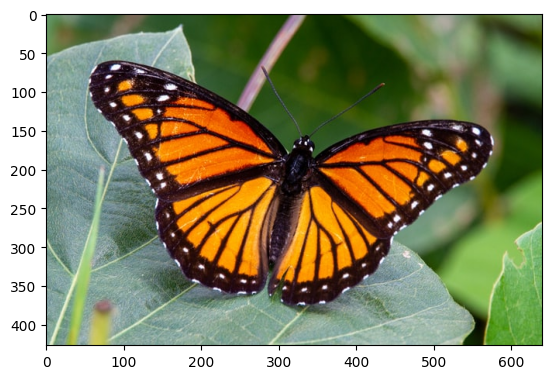

In [4]:
# преобразуем изображение в массив
img_matrix = np.array(img)

# (высота, ширина, число каналов)
print(f"Image array shape: {img_matrix.shape}")

plt.imshow(img_matrix);

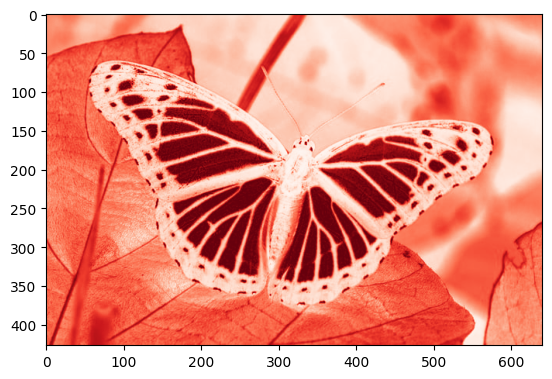

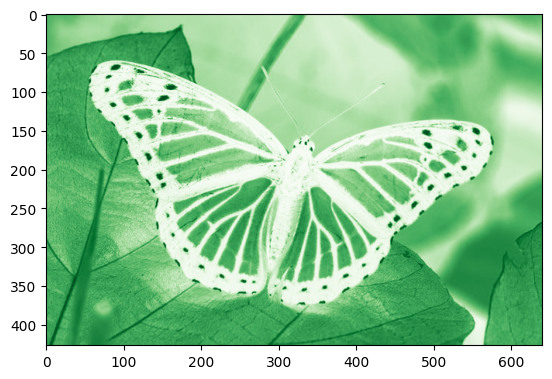

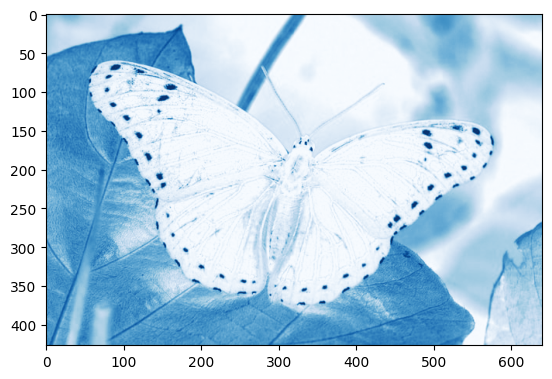

In [5]:
# посмотрим на все каналы изображения отдельно
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

Все действия по редактированию картинки сводятся к математике. Например, чтобы осветлить картинку, нужно прибавить к каждому пикселю какое-то число. Часто такие математические действия над картинками записывают в виде операции свёртки. Свёртка принимает на вход одну картинку, а на выход отдаёт новую, переработанную.

# 2. Пробуем применить свёртки к картинке

**Необязательное задание:** один из семенирстов собрал [коллекцию ручных задачек на свёртки.](https://fulyankin.github.io/deep_learning_masha_book/problem_set_05_conv/problem_01.html) Чтобы лучше почувствовать, как работают разные части свёрточных сеток, можно попробовать порешать эти задачки. К каждой из них на страничке есть решение.

### Класс torch.nn.Conv2d

In [6]:
import torch.nn as nn

nn.Conv2d

torch.nn.modules.conv.Conv2d

В **PyTorch** свёрточный слой представлен в модуле `torch.nn` классом [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- `in_channels`: количество входных каналов
- `out_channels`: количество выходных каналов
- `kernel_size`: размер ядра
- `stride`: шаг
- `padding`: паддинг
- `padding_mode`: режим паддинга  (`'zeros'`, `'reflect'` и др.)
- `dilation`: растяжение

#### `kernel_size`

**Размер ядра**. `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свёртка изображения.

**`kernel_size=3`**

![no_padding_no_strides.gif](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/no_padding_no_strides.gif)

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic).

#### `stride`

**Шаг**. Задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

**`stride=2`**

![no_padding_strides.gif](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/no_padding_strides.gif)

#### `padding`

**Паддинг**. Количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**`padding=1`**

![same_padding_no_strides.gif](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/same_padding_no_strides.gif)

### Класс MaxPool2d

In [7]:
import torch.nn as nn

nn.MaxPool2d

torch.nn.modules.pooling.MaxPool2d

В **PyTorch** уменьшает размерность, сохраняя наиболее «выразительные» признаки (максимумы), представлен в модуле `torch.nn` классом [`MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) с параметрами:
- `kernel_size`: размер ядра
- `stride`: шаг
- `padding`: паддинг (по умолчанию 0)
- `padding_mode`: режим паддинга  (`'zeros'`, `'reflect'` и др.)
- `dilation`: растяжение

![MaxPooling.png](https://media.geeksforgeeks.org/wp-content/uploads/Screenshot-from-2017-08-15-17-04-02.png)

Изображение взято [здесь](https://www.geeksforgeeks.org/computer-vision/apply-a-2d-max-pooling-in-pytorch/).

### Класс Flatten

В **PyTorch** операция выпрямления (преобразования многомерного тензора в вектор) представлена в модуле torch.nn классом [`Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html).

In [8]:
import torch.nn as nn

nn.Flatten

torch.nn.modules.flatten.Flatten

![Flatten.png](https://raw.githubusercontent.com/hse-ds/iad-deep-learning/refs/heads/master/2024/seminars/02.%20Image%20Convolution/static/Flatten.png)

## Свёртка изображений

Чем может быть полезна свертка при работе с изображениями? Свертки детектируют **паттерны на картинках** – цвета и сочетания цветов, небольшие объекты. Обычно значения свертки являются обучаемыми параметрами нейрости. Однако существуют "готовые" свертки, настроенные на определенные паттерны.

Например, оператор Собеля (свертка с определенными параметрами) используется для детекции границ на изображении. Применим этот оператор. Для этого пока не будем пользоваться классом `torch.nn.Conv2d`, а возьмём соответствующую функцию из модуля `torch.nn.functional`.

In [9]:
import torch

# В этом модуле примерно все те же самые операторы, что и в `torch.nn`,
# но только представлениы они не в виде классов, а виде функций.
from torch.nn.functional import conv2d

Конвертируем изображение в тензор и переставим размерности в порядке `(batch_size, n_channels, height, width)`, который принят в **PyTorch**.

In [10]:
img_matrix.shape

(427, 640, 3)

In [11]:
img_tensor = torch.tensor(img_matrix, dtype=torch.float)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
img_tensor.size()

torch.Size([1, 3, 427, 640])

Зададим оператор Собеля для детектирования горизонтальных границ

In [12]:
sobel_hor = [
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
]

# одна матрица на каждый канал картинки
kernel = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

In [13]:
# свернём картинку с подготовленным ядром свёртки
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size()

torch.Size([1, 425, 638, 1])

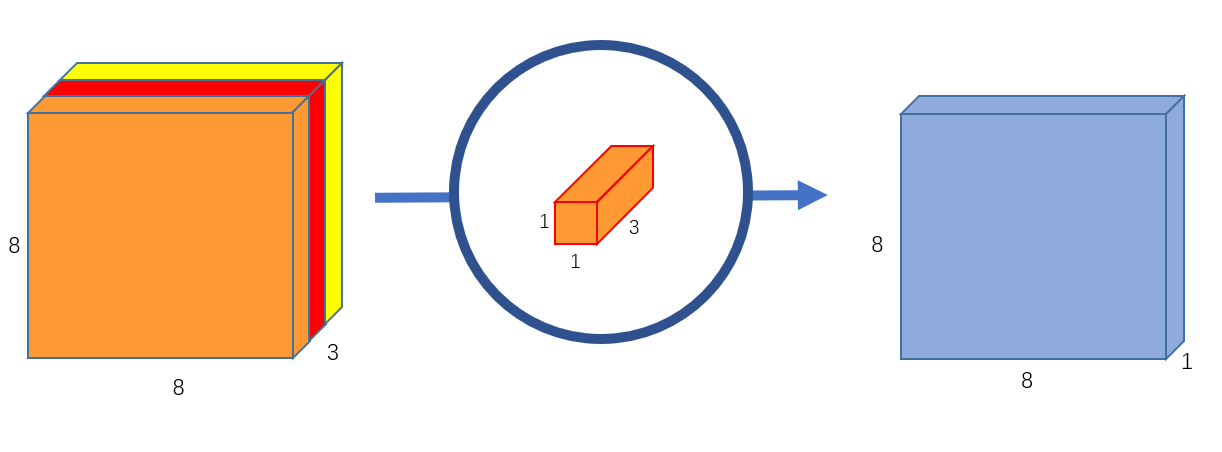

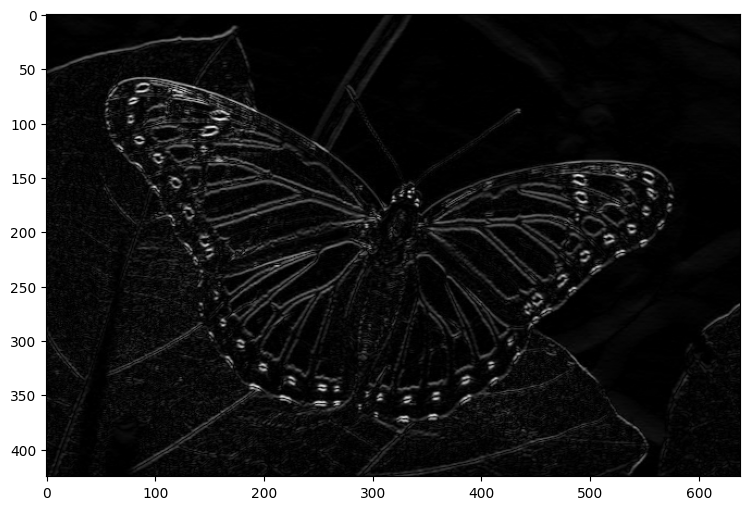

In [14]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]), cmap='gray');

Проделаем то же самое для детектирования вертикальных границ

In [15]:
sobel_ver = [
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
]

# одна матрица на каждый канал картинки
kernel = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)

img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()

torch.Size([1, 425, 638, 1])

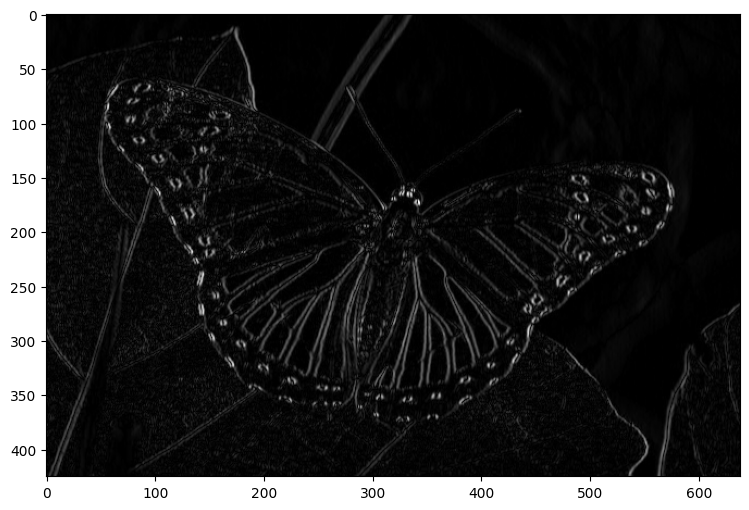

In [16]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]), cmap='gray');

Объединим два изображения

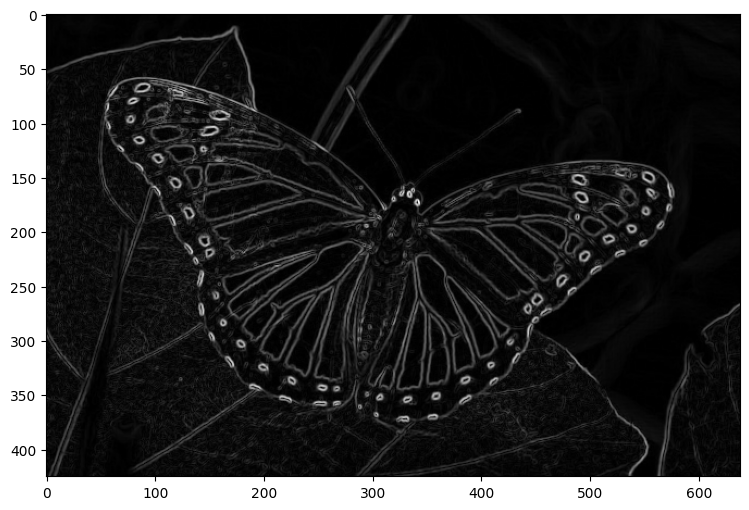

In [17]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0], cmap='gray');

# 3. Обучаем полносвязную нейросеть

Попробуем обучить полносвязную нейросеть для классификации картинок. Мы уже делали подобную штуку на первом семинаре, поэтому просто вспомним все необходимые нам для этого кусочки.


In [18]:
import torch
import torchvision

import torch.nn.functional as F
from torch import nn

from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST


Для начала подгрузим данные.

In [19]:
transform = torchvision.transforms.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,)),
])

Для того, чтобы нейронка корректно обучалась картинки обычно нормализуют на отезок $[-1,1]$. Такая нормализация довольно сильно ускоряет алгоритм обратного распространения ошибки, так как градиенты в рамках одного слоя могут оказываться разных знаков.

# Из чего состоит  нейросеть

Нам нужно разобраться как делать три вещи:

1. Как обрабатывать поток данных и отправлять его в сетку
2. Как сделать сетку
3. Как написать цикл обучения

## Как формировать батчи и отправлять их в сетку

С данными помогают работать две абстракции: `Dataset` и `DataLoader`.

`Dataset` умеет выдавать по индексу некоторый элемент и помогает итерироваться по данным. Чтобы работать с данными и применять к ним преобразования, например, аугментации, — нужно создать свой класс унаследованный от `torch.utils.data.Dataset`.

У такого класса должно быть два метода:

* `__len__` — возвращает информацию о том, сколько объектов у нас в датасете
* `__getitem__` — возвращает семпл и таргет к нему

Ниже - пример такого класса.

    class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""

    def __init__(self, x, y):
        self.x=x
        self.y=y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {'sample': torch.tensor(x[idx, :], dtype=torch.float), 'target': y[idx]}

Для супер стандартных датасетов класс не надо писать - в PyTorch это уже сделали за нас :)

In [20]:
train_set = MNIST('.MNIST', transform=transform, train=True, download=True)
val_set = MNIST('.MNIST', transform=transform, train=False, download=True)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size     = 256,
    shuffle        = True,
    num_workers    = 0
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size    = 4096,
    shuffle       = False,
    num_workers   = 0
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


Здесь:
- `batch_size` — размер батча, на которые даталоадер будет делить данные перед каждой эпохой;
- `shuffle` — если `True`, то перед каждой эпохой и делением на батчи данные будут перемешаны. Shuffle обычно ставится `True` для обучающих данных, и `False` для тестовых.

Подготовим функцию для отрисовки процесса обучения.

In [21]:
from IPython.display import clear_output

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

Опишем функции для обучения и валидации модели.

In [26]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    """Одна эпоха обучения"""
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_desc):
    """Прогнозы на валидации"""

    val_loss, val_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        val_loss += loss.item() * images.shape[0]
        val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    return val_loss, val_accuracy


def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler=None):
    """Обучение модели"""
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        val_loss, val_accuracy = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # функция для смены lr по расписанию
        if scheduler is not None:
            scheduler.step()

        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

    # печатаем метрики
    print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

### Собираем нейросеть

Соберем полносвязную сеть из 3 слоёв с $32$, $16$, и $10$ нейронами. На всех промежуточных слоях используем `ReLU` в качестве функции активации. Последний слой должен возвращать логиты (вероятности) для дальнейшей классификации.

In [27]:
class FcNet(nn.Module):
    def __init__(self, input_shape, hide_neurons=32, num_classes=10):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),                                # превращаем картинку 28х28 в вектор размером 784
            nn.Linear(input_shape, hide_neurons),        # линейный слой, преобразующий вектор размера 784 в вектор размера 64
            nn.ReLU(),                                   # нелинейность
            nn.Linear(hide_neurons, hide_neurons // 2),  # линейный слой, преобразующий вектор размера 784 в вектор размера 32
            nn.ReLU(),                                   # нелинейность
            nn.Linear(hide_neurons//2, num_classes),     # линейный слой, преобразующий вектор размера 784 в вектор размера 10
        )

    def forward(self, x):
        return self.model(x)

In [28]:
IMG_SIZE = 28
NUM_EPOCH = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_fc = FcNet(IMG_SIZE**2).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_fc.parameters(), lr=0.01, momentum=0)

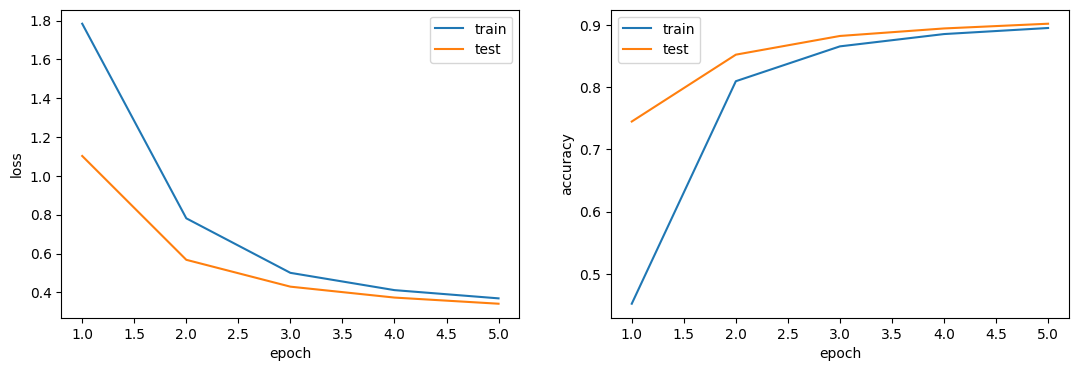

Epoch: 5, loss: 0.3415851723194122, accuracy: 0.9024


In [29]:
train(model_fc, optimizer, criterion, train_loader, val_loader, NUM_EPOCH)

Давайте попробуем построить предсказания на валидационной выборке и посмотрим, на примеры картинок, где модель ошиблась. Иногда бывает полезно отсматривать конкретные примеры ошибок, чтобы подумать как можно улучшить модель.

In [30]:
def predict(model, val_loader):
    X, y, logit = [], [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(val_loader):
        X.extend(x_batch)
        y.extend(y_batch)
        x_batch = x_batch.to(device)

        with torch.no_grad():
            logits = model(x_batch)

        logit.extend(torch.max(logits, 1)[1].cpu().numpy())
    return np.array(X), np.array(y), np.array(logit)

In [31]:
X_test, y_test, y_pred = predict(model_fc, val_loader)

In [32]:
errors = y_test != y_pred

X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = y_pred[errors]

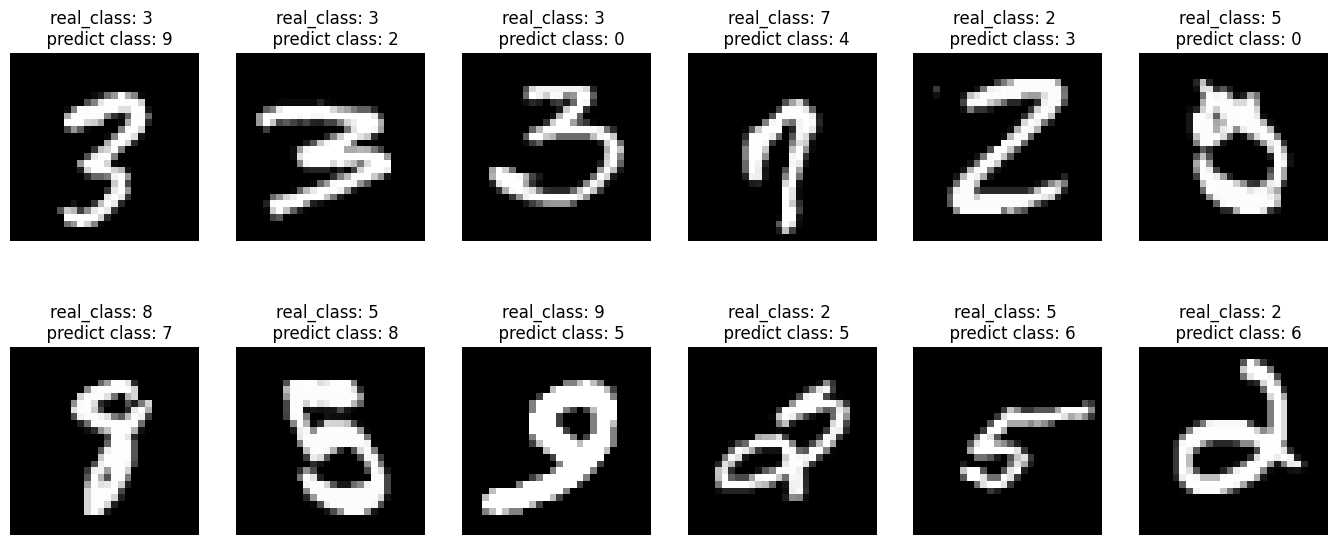

In [33]:
cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(X_err[random_index], (1, 2, 0)), cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred_err[random_index]))
plt.show()

# Обучаем свёрточную нейронную сеть

По аналогии с предыдущим примером обучим свёрточную нейронную сеть. В части `encoder` зададим следующие слои:

- Свёрточный слой с 2 ядрами размером 3
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Свёрточный слой с 4 ядрами размером 3
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Свёрточный слой с 8 ядрами размером 3
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)

В части `classifier` зададим следующие слои:

- Полносвязный слой с 32 нейронами (аккуратно осознайте сколько нейронов будет на входе и почему)
- Функция активации ReLU
- Выходной слой с 10 нейронами

In [34]:
class ConvNet(nn.Module):

    def __init__(self, image_channels=1):
        super().__init__()

        self.encoder = nn.Sequential(  # 28 x 28 x 1
            nn.Conv2d(in_channels=image_channels, out_channels=4,
                      kernel_size=3, padding='same'),  # 28 x 28 x 4
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14 x 14 x 4

            nn.Conv2d(in_channels=4, out_channels=8,
                      kernel_size=3, padding='same'),  # 14 x 14 x 8
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7 x 7 x 8

            nn.Conv2d(in_channels=8, out_channels=16,
                      kernel_size=3, padding='same'),  # 7 x 7 x 16
            nn.ReLU(),
            nn.MaxPool2d(2)  # 3 x 3 x 16 = 144
        )

        self.head = nn.Sequential(
            nn.Linear(in_features=144, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10)
        )

    def forward(self, x):

        # x: B x 1 x 28 x 28
        out = self.encoder(x)   # out: B x 392
        out = nn.Flatten()(out) # out: B x 128
        out = self.head(out)    # out: B x 10
        return out

    def get_embedding(self, x):
        out = self.encoder(x)
        return nn.Flatten()(out)

In [35]:
NUM_EPOCH = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_cnn = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0)

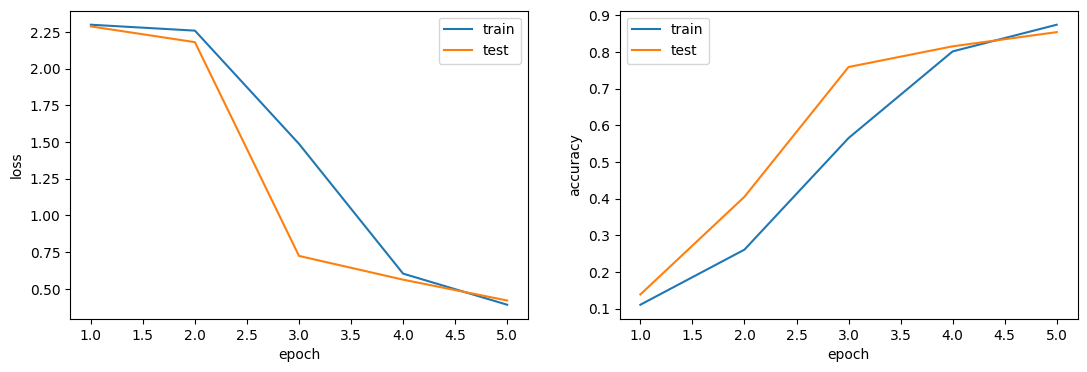

Epoch: 5, loss: 0.4200240912914276, accuracy: 0.8539


In [36]:
train(model_cnn, optimizer, criterion, train_loader, val_loader, NUM_EPOCH)

Посмотрим на ошибки и увидим, что объекты, где наша модель их допускает, более сложные, чем в случае с полносвязной сетью.

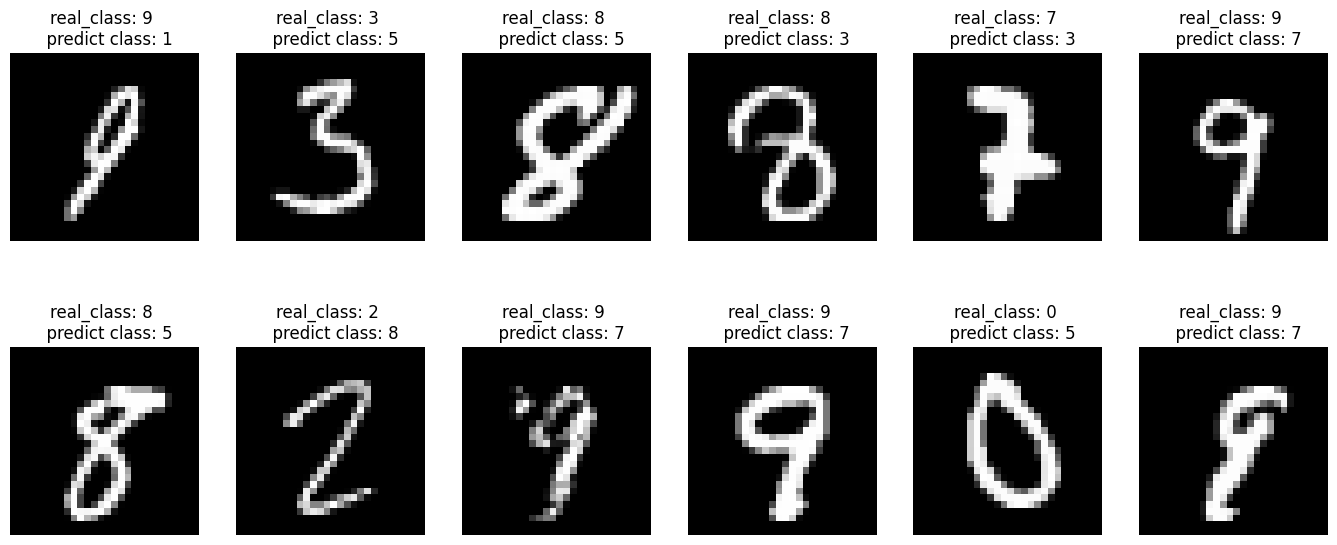

In [37]:
X_test, y_test, y_pred = predict(model_cnn, val_loader)

errors = y_test != y_pred

X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = y_pred[errors]

cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(X_err[random_index], (1, 2, 0)), cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred_err[random_index]))
plt.show()